The goal of this noteook is to attempt to reproduce the behavior of the Equations in Ghazaryan et al. using the network library infrastructure that I have built up so far.

In [3]:
# Importin my needed libraries
import numpy as np 
from matplotlib import pyplot as plt
import networkx as nx
import DynaNet
import Equations

from numpy import linalg

The situation that I am reproducing directly from Ghazaryan, 
>Traveling wave profiles for parameters $\gamma=1000$, $\beta=20$, $p=2$, $\omega=0.1$, $\alpha=1$, $c=2$.

In order to do this with my library, I am considering a multiplexed network consisting of two line networks to simulate the 1D behavior of the coupled equations. That is, there are two idential discretizations of a straight line sharing a node set and coupled at every node. The next issue is that their work uses a change of variables to a stationary frame. This is difficult to interpret in a graph framework, so I will instead use some post-processing to make an analogous frame shift

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.

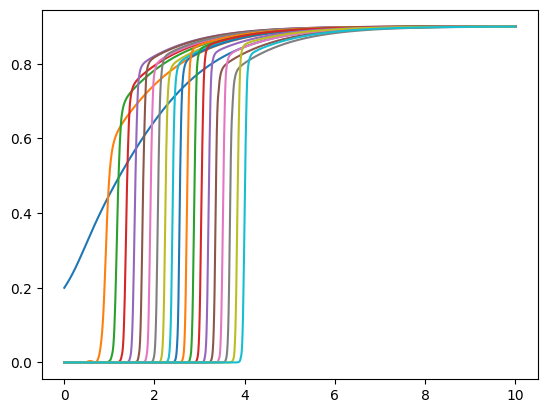

In [136]:
# Set graph parameters
graph_size = 20

# Line graphs
ident = np.identity(graph_size)
adj = np.roll(ident, 1) + np.roll(ident, -1) 
adj[0, 0] = 0
adj[graph_size-1, graph_size-1] = 0
online, offline = adj, adj
print(adj)

# Create a multiplexed dynamic graph model
MG = DynaNet.MultiplexDynaNet([online, offline])
MG.generate_incidence()
MG.generate_laplacian()
MG.generate_multi_laplacian()

# Set up our multiplexed Fisher-KPP equation
MDE = Equations.MultiplexFisherKPPStep

# Set up equation parameters
ks = np.array([-0.001 for ii in range(graph_size)] + [-0.002 for ii in range(graph_size)])
vs = np.zeros(2*graph_size)
epsilon = 0.1

def coupling(state):
    u = state[:graph_size]
    v = state[graph_size:]
    u_next = 0.1*(-u + 1000*u*(1-u)/(1+np.exp(-20*(v-1))))
    v_next = 1-v*(1+u)**2
    return np.concatenate((u_next, v_next))

# Set up initial conditions
t0 = 0
tf = 10
nt = 1000
A, k, B = 0.2, 10, .7
u0 = A*np.exp(-k*np.arange(graph_size))
v0 = B*np.ones(graph_size)
f0 = np.concatenate((u0, v0))

# Run simulation
MG.solve_ivp(MDE, f0, t0, tf, nt, ks, vs, coupling)
res = MG.solve_ivp_results

for ii in range(graph_size):
    plt.plot(res.t, res.y[ii, :], label=f'{ii}')
    #plt.legend()
plt.show()

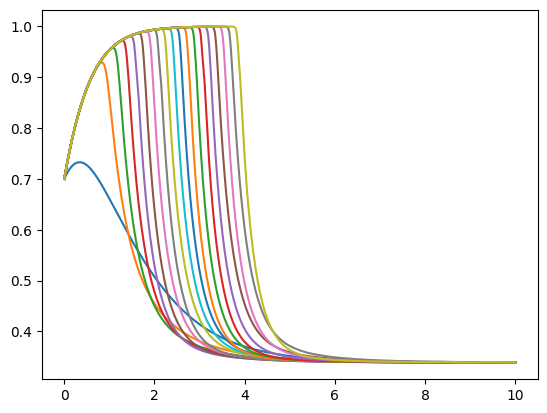

In [137]:
for ii in range(graph_size, 2*graph_size-1):
    plt.plot(res.t, res.y[ii, :], label=f'{ii}')
    #plt.legend()
plt.show()

Now we try to plot these curves in traveling wave style. This means letting $\xi = x-ct$. But since $x$ is discrete in this case, $\xi$ is also necesarily discrete. To remedy this, we fix an x atour halfway node, (node 24 in this case)

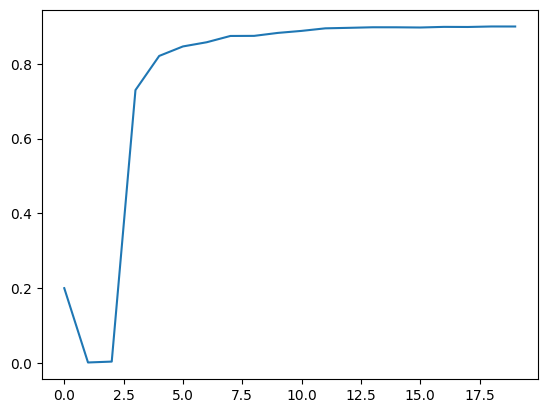

In [138]:
cross_section = np.array([res.y[ii, np.argmin(np.abs(res.t-ii/2))] for ii in range(graph_size)])
plt.plot(range(graph_size), cross_section)

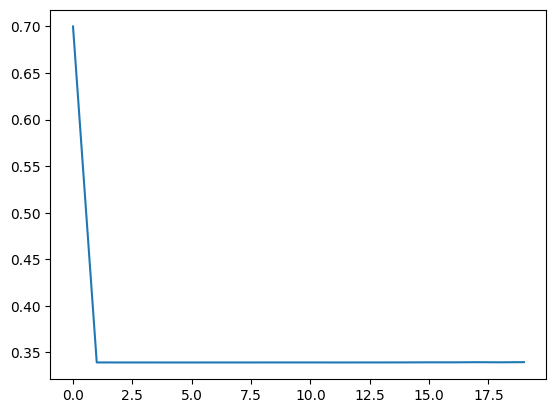

In [139]:
cross_section = np.array([res.y[ii, np.argmin(np.abs(res.t-(ii-graph_size)/0.02))] for ii in range(graph_size, 2*graph_size)])
plt.plot(range(graph_size), cross_section)

In [140]:
from mpl_toolkits.mplot3d import axes3d

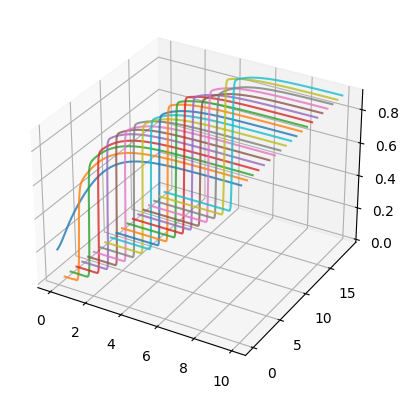

In [141]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
y_ticks = list(range(graph_size))
for ii in y_ticks:    
    ax.plot(res.t, res.y[ii, :], zs=ii, zdir='y', alpha=0.8)

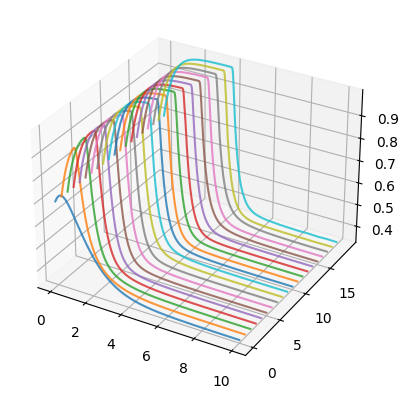

In [142]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
y_ticks = list(range(graph_size))
for ii in y_ticks:    
    ax.plot(res.t, res.y[ii+graph_size, :], zs=ii, zdir='y', alpha=0.8)

Which looks like what we expect for the regime. I can verify later. But the other shape is to come.

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0.

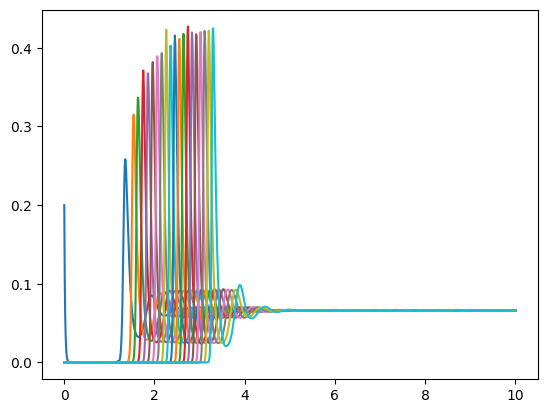

In [159]:
# Set graph parameters
graph_size = 20

# Line graphs
ident = np.identity(graph_size)
adj = np.roll(ident, 1) + np.roll(ident, -1) 
adj[0, 0] = 0
adj[graph_size-1, graph_size-1] = 0
online, offline = adj, adj
print(adj)

# Create a multiplexed dynamic graph model
MG = DynaNet.MultiplexDynaNet([online, offline])
MG.generate_incidence()
MG.generate_laplacian()
MG.generate_multi_laplacian()

# Set up our multiplexed Fisher-KPP equation
MDE = Equations.MultiplexFisherKPPStep

# Set up equation parameters
ks = np.array([-0.001 for ii in range(graph_size)] + [-0.002 for ii in range(graph_size)])
vs = np.zeros(2*graph_size)
epsilon = 0.1

def coupling(state):
    u = state[:graph_size]
    v = state[graph_size:]
    u_next = 60*(-u + 5*u*(1-u)/(1+np.exp(-20*(v-1))))
    v_next = 1-v*(1+u)**2
    return np.concatenate((u_next, v_next))

# Set up initial conditions
t0 = 0
tf = 10
nt = 1000
A, k, B = 0.2, 10, .7
u0 = A*np.exp(-k*np.arange(graph_size))
v0 = B*np.ones(graph_size)
f0 = np.concatenate((u0, v0))
f0.astype(dtype=np.longdouble)

# Run simulation
MG.solve_ivp(MDE, f0, t0, tf, nt, ks, vs, coupling)
res = MG.solve_ivp_results

for ii in range(graph_size):
    plt.plot(res.t, res.y[ii, :], label=f'{ii}')
    #plt.legend()
plt.show()

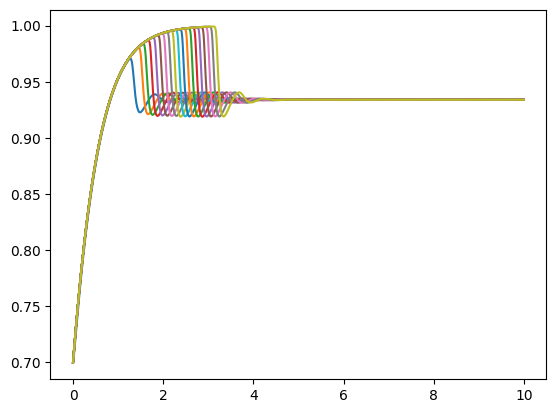

In [160]:
for ii in range(graph_size, 2*graph_size-1):
    plt.plot(res.t, res.y[ii, :], label=f'{ii}')
    #plt.legend()
plt.show()

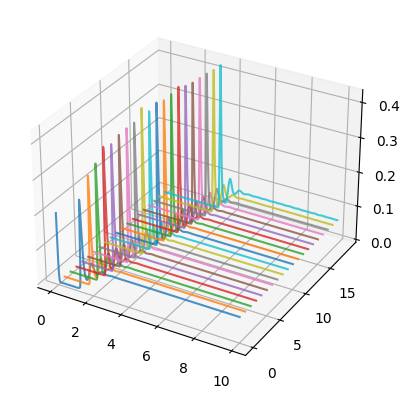

In [161]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
y_ticks = list(range(graph_size))
for ii in y_ticks:    
    ax.plot(res.t, res.y[ii, :], zs=ii, zdir='y', alpha=0.8)

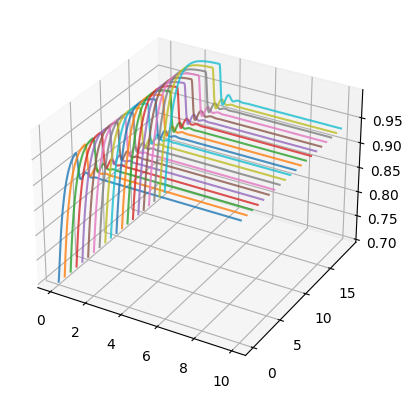

In [162]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
y_ticks = list(range(graph_size))
for ii in y_ticks:    
    ax.plot(res.t, res.y[ii+graph_size, :], zs=ii, zdir='y', alpha=0.8)

Which reproduces figure 7 from Ghazaryan if we take a cross section in time